# Accent classification with concatenated frames

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
#torch.multiprocessing.set_start_method("spawn")

In [2]:
# Restart from here
DEV = False
EPOCHS = 2

DEBUG = False
NUM_CONCAT = 20

In [3]:
# autoreloads
%reload_ext autoreload
%autoreload 1
%aimport parameters

# Allows to load modules from parent directory
from time import time
import inspect, sys, os, json
from os.path import dirname, abspath
sys.path.append(dirname(dirname(abspath(inspect.getfile(inspect.currentframe())))))

from pathlib import Path
from os import makedirs

from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd

from data.data_loader import create_binarizer, get_accents_counts
from utils import count_parameters

from tensorboardX import SummaryWriter

import math

from torch.utils.data import DataLoader, Dataset
from data.data_loader import SpectrogramAccentDataset, BucketingSampler, AudioDataLoader

In [4]:
param = parameters.get_parameters(dev=DEV, epochs=EPOCHS, us_en=True)

## Utilities

In [5]:
# Tensorboard
exp_name = f'__tmp__no_kaldi_{time()}'
tb_path = Path(param['tensorboard_dir']) / exp_name
makedirs(tb_path, exist_ok=True)
tb_writer = SummaryWriter(tb_path)

def val_cnts(list_):
    return pd.Series(list_).value_counts()

def extract_num (s):
    return ''.join([c if c.isdigit() else '' for c in s])

def ids_list(manifest):
    ids = []
    with open(manifest) as f:
        for l in f:
            s = l.split('/')
            ids.append(f'{s[3]}-{s[5].split(".")[0]}')
    return ids

def make_accent_dict(manifest_path):
    accent_dict = {}
    class_dict = {}
    with open(manifest_path) as f:
        for l in f:
            wav, txt, acc = l.split(',')
            num = extract_num(wav)
            accent = acc.strip()
            if accent not in class_dict:
                new_key = 0 if (len(class_dict) == 0) else max(class_dict.values()) + 1
                class_dict[accent] = new_key
            accent_dict[num] = class_dict[accent]
    return accent_dict, {v: k for k, v in class_dict.items()}

## Data Loading

In [6]:
def collate_fn(batch_tot):
    """This function takes list of samples and assembles a batch. It is intended to used in PyTorch DataLoader."""
    res, __, targets = zip(*batch_tot)
    
    lens = [r.size(1) for r in res]

    concats = []
    for mat in res:
        num_frames = mat.shape[1]
        frame_len = mat.shape[0]

        mat = mat.transpose(1, 0)
        
        pre = np.stack([mat[0]] * NUM_CONCAT)
        post = np.stack([mat[-1]] * NUM_CONCAT)

        mat = np.concatenate([pre, mat, post])

        mat_tensor = torch.tensor(mat)
        mat_tensor = mat_tensor.view(-1)

        for i in range(NUM_CONCAT, num_frames + NUM_CONCAT):
            concat = mat_tensor[(i - NUM_CONCAT) * frame_len:(1 + i + NUM_CONCAT) * frame_len]

            concats.append(concat)
            #targets.append(accent_dict[id_])
    res = torch.stack(concats)
    
    tar = []
    [tar.extend([t] * lens[i]) for i, t in enumerate(targets)]
    tar = torch.tensor(tar).view(-1)
    
    # shuffling in batch
    idx = torch.randperm(tar.nelement())
    res = res[idx]
    tar = tar[idx]
    
    return res, tar

class ConcatDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        """
        Creates a data loader for SpeechDatasets.
        """
        super(ConcatDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = collate_fn

In [7]:
accent_binarizer = create_binarizer(param['train_manifest'])
labels = accent_binarizer.classes_

In [8]:
train_dataset = SpectrogramAccentDataset(audio_conf=param['audio_conf'], 
                                        manifest_filepath=param['train_manifest'], 
                                        labels=labels,
                                        normalize=True, 
                                        augment=param['augment'], 
                                        accent_binarizer=accent_binarizer,
                                        kaldi=False)

train_sampler = BucketingSampler(train_dataset, batch_size=param['batch_size'])

train_loader = ConcatDataLoader(train_dataset,
                                num_workers=param['num_worker'], 
                                batch_sampler=train_sampler)

In [9]:
test_dataset = SpectrogramAccentDataset(audio_conf=param['audio_conf'], 
                                        manifest_filepath=param['test_manifest'], 
                                        labels=labels,
                                        normalize=True, 
                                        augment=False, 
                                        accent_binarizer=accent_binarizer,
                                        kaldi=False)

test_loader = ConcatDataLoader(test_dataset,
                                num_workers=param['num_worker'], 
                                batch_size=param['batch_size'])

## Model definition

In [10]:
class AccentClassifier(nn.Module):
    def __init__(self,
                 input_size,
                 num_classes,
                 DEBUG = False,):
        
        super(AccentClassifier, self).__init__()

        self._DEBUG = DEBUG
        
        self.batchnorm = nn.BatchNorm1d(input_size)
        
        self.fc = nn.Sequential( 
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes),
            nn.ReLU(),
        )

        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        if self._DEBUG:
            print('input x', x.size())

        x = self.batchnorm(x)
        
        if self._DEBUG:
            print('after batchnorm', x.size())

        x = self.fc(x)
        
        if self._DEBUG:
            print('after fc', x.size())
            
        x = self.softmax(x)
        
        if self._DEBUG:
            print('after softmax', x.size())
        return x

## Optimizer

In [ ]:
model = AccentClassifier(input_size=(2 * NUM_CONCAT + 1) * train_dataset[0][0].size(0), 
                         num_classes=len(accent_dict),
                         DEBUG=DEBUG)

if param['cuda']:
    model.cuda()
    
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=param['lr'][0])

print(model)
print('Model parameters counts:', count_parameters(model))

In [12]:
model = AccentClassifier(input_size=(2 * NUM_CONCAT + 1) * 40, 
                         num_classes=2,
                         DEBUG=DEBUG)

In [13]:
model

AccentClassifier(
  (batchnorm): BatchNorm1d(1640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Sequential(
    (0): Linear(in_features=1640, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=2, bias=True)
    (3): ReLU()
  )
  (softmax): Softmax()
)

## Training

In [193]:
SILENT = True
    
best_model = None
prev_acc = 0
## Train
for epoch in range(1, param['epochs'] + 1):
    
    print(f'## EPOCH {epoch} ##')
    print(f'Training:')
    model.train()
    
    # train
    epoch_losses = []
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        inputs, target_accents = data
        inputs = inputs.cuda()
        target_accents = target_accents.cuda()
        
        # Forward pass
        out = model(inputs)

        loss = criterion(out, target_accents)
        epoch_losses.append(loss)
        
        if not SILENT:
            print(f'Iteration {i+1}/{len(train_loader):<4}loss: {loss:0.3f}')
        
        # Gradient
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    epoch_loss = sum(epoch_losses) / len(train_loader)
    tb_writer.add_scalar('stats/train_loss', epoch_loss, epoch)
    print(f'Epoch {epoch} average loss: {epoch_loss:0.3f}')
        
    # validate
    print(f'Testing:')
    model.eval()
    acc = 0
    tot = 0
    with torch.no_grad():
        epoch_val_losses = []
        for data in tqdm(test_loader, total=len(test_loader)): ## ## 
            inputs, target_accents = data
            inputs = inputs.cuda()
            target_accents = target_accents.cuda()
            
            out = model(inputs)

            val_loss = criterion(out, target_accents)
            epoch_val_losses.append(val_loss)
            
            out_arg = np.argmax(out, axis=1).cuda()
            diff = torch.eq(out_arg, target_accents)
            acc += torch.sum(diff)
            tot += len(target_accents)
        
        acc = acc.item() / tot * 100
        epoch_val_loss = sum(epoch_val_losses) / len(test_loader) ##
        
    tb_writer.add_scalar('stats/accuracy', acc, epoch)
    print(f'Accent classification accuracy: {acc:0.2f}%')

    tb_writer.add_scalar('stats/val_loss', epoch_val_loss, epoch)
    print(f'Average validation loss: {val_loss:0.3f}')
    
    if acc > prev_acc:
        print('New best model found.')
        best_model = model
        prev_acc = acc

## EPOCH 1 ##
Training:



Epoch 1 average loss: 0.611
Testing:



Accent classification accuracy: 50.53%
Average validation loss: 0.792
New best model found.
## EPOCH 2 ##
Training:



Epoch 2 average loss: 0.743
Testing:



Accent classification accuracy: 50.53%
Average validation loss: 0.693


## Tests

In [215]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black") #if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [216]:
loader = test_loader
best_model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for data in tqdm(loader, total=len(loader)):
        inputs, target_accents = data
        inputs = inputs.cuda()
        target_accents = target_accents.cuda()
        
        out = best_model(inputs)
        
        y_true.extend(target_accents)
        y_pred.append(np.argmax(out, axis=1))
        
    y_pred = torch.cat(y_pred)
            
    y_true_labels = [accent_dict[int(i)] for i in y_true]
    y_pred_labels = [accent_dict[int(i)] for i in y_pred]

cnf_mat = confusion_matrix(y_true_labels, y_pred_labels)

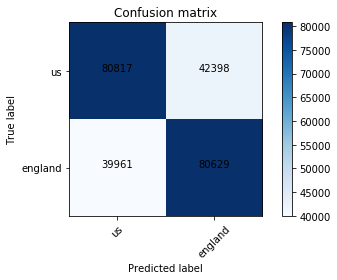

In [217]:
plot_confusion_matrix(cnf_mat, classes=accent_dict.values())

In [218]:
from sklearn import metrics
print(metrics.classification_report(y_true_labels, y_pred_labels))

             precision    recall  f1-score   support

    england       0.67      0.66      0.66    123215
         us       0.66      0.67      0.66    120590

avg / total       0.66      0.66      0.66    243805



## Test at utterance level

In [219]:
def collate_fn(batch_tot):
    """This function takes list of samples and assembles a batch. It is intended to used in PyTorch DataLoader."""
    res, targets = zip(*batch_tot)
    lens = [len(r) for r in res]

    concats = []
    for mat in res:
        num_frames = mat.shape[0]
        frame_len = mat.shape[1]

        pre = np.stack([mat[0]] * NUM_CONCAT)
        post = np.stack([mat[-1]] * NUM_CONCAT)

        mat = np.concatenate([pre, mat, post])

        mat_tensor = torch.tensor(mat)
        mat_tensor = mat_tensor.view(-1)

        for i in range(NUM_CONCAT, num_frames + NUM_CONCAT):
            concat = mat_tensor[(i - NUM_CONCAT) * frame_len:(1 + i + NUM_CONCAT) * frame_len]

            concats.append(concat)
            #targets.append(accent_dict[id_])
            
    res = torch.stack(concats)
    
    tar = []

    [tar.extend([t] * lens[i]) for i, t in enumerate(targets)]
    tar = torch.tensor(tar)
    
    # shuffling in batch
#     idx = torch.randperm(tar.nelement())
#     res = res[idx]
#     tar = tar[idx]
    
    return res, tar, lens

class UtteranceConcatDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        """
        Creates a data loader for SpeechDatasets.
        """
        super(UtteranceConcatDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = collate_fn

In [220]:
ut_test_dict, ut_dict = make_accent_dict('../data/CommonVoice_dataset/splits/for_notebooks/us-en_test.csv')

ut_test_dataset = ConcatDataset('../data/CommonVoice_dataset/kaldi/test-norm', 
                              ids_list('../data/CommonVoice_dataset/splits/for_notebooks/us-en_test.csv'), 
                              test_dict)

ut_test_loader = UtteranceConcatDataLoader(test_dataset, 
                                shuffle=False, 
                                num_workers=param['num_worker'],
                                batch_size=param['batch_size'])

ut_dev_dict, __ = make_accent_dict('../data/CommonVoice_dataset/splits/for_notebooks/us-en_dev.csv')

ut_dev_dataset = ConcatDataset('../data/CommonVoice_dataset/kaldi/dev-norm', 
                              ids_list('../data/CommonVoice_dataset/splits/for_notebooks/us-en_dev.csv'), 
                              test_dict)

ut_dev_loader = UtteranceConcatDataLoader(test_dataset, 
                                shuffle=False, 
                                num_workers=param['num_worker'],
                                batch_size=param['batch_size'])

In [221]:
def cnf_for_loader(loader):
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in tqdm(loader, total=len(loader)):
            inputs, target_accents, lens = data
            inputs = inputs.cuda()
            target_accents = target_accents.cuda()

            out = best_model(inputs)
            out = np.argmax(out, axis=1)

            i = 0
            for l in lens:                
                y_true.append(target_accents[i])
                y_pred.append(round(sum(out[i:i+l-1]).item()/l))
                i += l

        y_true_labels = [ut_dict[int(i)] for i in y_true]
        y_pred_labels = [ut_dict[int(i)] for i in y_pred]

    return y_true_labels, y_pred_labels

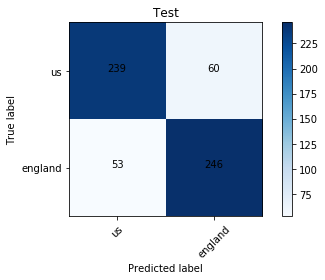

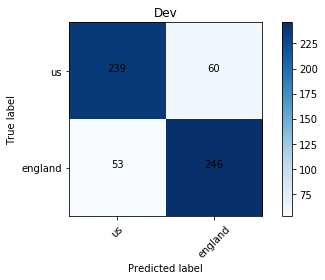

In [222]:
best_model.eval()
y_t_test, y_p_test = cnf_for_loader(ut_test_loader)
test_cnf_mat = confusion_matrix(y_t_test, y_p_test)
y_t_dev, y_p_dev = cnf_for_loader(ut_test_loader)
dev_cnf_mat = confusion_matrix(y_t_dev, y_p_dev)

plot_confusion_matrix(test_cnf_mat, title='Test', classes=accent_dict.values())
plot_confusion_matrix(dev_cnf_mat, title='Dev', classes=accent_dict.values())

In [223]:
print('Test', metrics.classification_report(y_t_test, y_p_test))
print('Dev', metrics.classification_report(y_t_dev, y_p_dev))

Test              precision    recall  f1-score   support

    england       0.82      0.80      0.81       299
         us       0.80      0.82      0.81       299

avg / total       0.81      0.81      0.81       598

Dev              precision    recall  f1-score   support

    england       0.82      0.80      0.81       299
         us       0.80      0.82      0.81       299

avg / total       0.81      0.81      0.81       598



## Data Loading old

In [6]:


def make_accent_dict(manifest_path):
    accent_dict = {}
    class_dict = {}
    with open(manifest_path) as f:
        for l in f:
            wav, txt, acc = l.split(',')
            num = extract_num(wav)
            accent = acc.strip()
            if accent not in class_dict:
                new_key = 0 if (len(class_dict) == 0) else max(class_dict.values()) + 1
                class_dict[accent] = new_key
            accent_dict[num] = class_dict[accent]
    return accent_dict, {v: k for k, v in class_dict.items()}

def concatenate_ark(ark, accent_dict):
    concats = []
    targets = []

    for key, mat in ark:
        id_  = extract_num(key)

        if id_ in accent_dict:
            num_frames = mat.shape[0]
            frame_len = mat.shape[1]

            pre = np.stack([mat[0]] * NUM_CONCAT) 
            post = np.stack([mat[-1]] * NUM_CONCAT)

            mat = np.concatenate([pre, mat, post])

            mat_tensor = torch.tensor(mat)
            mat_tensor = mat_tensor.view(-1)

            for i in range(NUM_CONCAT, num_frames + NUM_CONCAT):
                concat = mat_tensor[(i - NUM_CONCAT) * frame_len:(1 + i + NUM_CONCAT) * frame_len]

                concats.append(concat)
                targets.append(accent_dict[id_])

    return torch.stack(concats), torch.tensor(targets)

def concatenated_dataset(kaldi_path, manifest_path):
    train_kaldi = kaldi_io.read_mat_ark(kaldi_path)
    accent_dict, class_dict = make_accent_dict(manifest_path)
    concats, targets = concatenate_ark(train_kaldi, accent_dict)
    return concats, targets, class_dict

In [7]:
class KaldiDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        assert len(X) == len(Y)
        self._input_size = X.size(1) 
        self.X, self.Y = X, Y
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    def __len__(self):
        return len(self.X)

In [8]:
X_tr, Y_tr, class_dict = concatenated_dataset(param['train_kaldi'], param['train_manifest'])

if param['cuda']:
    X_tr = X_tr.cuda(); Y_tr = Y_tr.cuda()

train_dataset = KaldiDataset(X_tr, Y_tr)
train_loader = DataLoader(train_dataset, 
                          shuffle=True, 
                          num_workers=0, 
                          batch_size=param['batch_size'])

In [9]:
X_te, Y_te, __ = concatenated_dataset(param['test_kaldi'], param['test_manifest'])

if param['cuda']:
    X_te = X_te.cuda(); Y_ter = Y_te.cuda()

test_dataset = KaldiDataset(X_te, Y_te)
test_loader = DataLoader(test_dataset, 
                          shuffle=True, 
                          num_workers=0, 
                          batch_size=param['batch_size'])